In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import glob, os
import pickle
import skimage
import skimage.transform
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
import matplotlib.patches as patches
import cv2

## 1. PREPARE THE DATASET

### 1.1 LOAD IMAGES, CORNERS AND MASKS

In [3]:
# LOAD AND SORT IMAGES FILENAMES INTO LISTS
image_dir = 'WashingtonOBRace'

img_filenames = glob.glob(os.path.join(image_dir, 'img_[0-9]*.png'))
img_filenames = sorted(img_filenames, key=lambda x:int(x[21:-4]))
print(f'Found {len(img_filenames)} image files in the directory "{image_dir}"')

mask_filenames = glob.glob(os.path.join(image_dir, 'mask_*.png'))
mask_filenames = sorted(mask_filenames, key=lambda x:int(x[22:-4]))
print(f'Found {len(mask_filenames)} mask files in the directory "{image_dir}"')

Found 308 image files in the directory "WashingtonOBRace"
Found 308 mask files in the directory "WashingtonOBRace"


In [4]:
print(mask_filenames[:10])

['WashingtonOBRace/mask_6.png', 'WashingtonOBRace/mask_8.png', 'WashingtonOBRace/mask_9.png', 'WashingtonOBRace/mask_10.png', 'WashingtonOBRace/mask_11.png', 'WashingtonOBRace/mask_12.png', 'WashingtonOBRace/mask_13.png', 'WashingtonOBRace/mask_14.png', 'WashingtonOBRace/mask_18.png', 'WashingtonOBRace/mask_19.png']


In [5]:
# READ AND STORE IMAGES AND MASKS INTO LISTS
imgs = [cv2.imread(filename, flags=cv2.IMREAD_COLOR) \
                                for filename in img_filenames]
imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]
print('loaded %d images' % len(imgs))

masks = [cv2.imread(filename, flags=cv2.IMREAD_GRAYSCALE) \
                                 for filename in mask_filenames]
print('loaded %d masks' % len(masks))

loaded 308 images
loaded 308 masks


(360, 360, 3) (360, 360)
[  0 255]


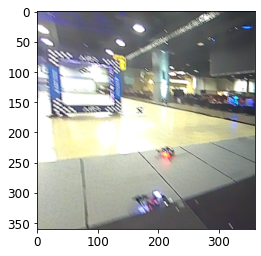

In [6]:
# HAVE AN INSIGHT
print(imgs[0].shape, masks[0].shape)
print(np.unique(masks[0]))
plt.figure()
plt.imshow(imgs[0])
plt.show()

In [7]:
# LOAD CORNERS COORDINATES INTO ARRAYS

# ATTENTIONS: 
# X/Y STANDS FOR COLUMN/ROW INDEX IN IMAGE
# THE 4 CORNER POINTS ARE PLACED CLOCKWISE STARTED FROM TOP LEFT
# DICTIONARY ORDERING(e.g., img_6.png LOCATED BACKWARDS THAN img_10.png)

corners_filename = os.path.join(image_dir, 'corners.csv')
corners = pd.read_csv(corners_filename, \
            names=['img_name', 'xtl', 'ytl', 'xtr', 'ytr', 'xbr', 'ybr', 'xbl', 'ybl'])
print(corners)
corners = corners.to_numpy()
print(corners.shape)

        img_name  xtl  ytl  xtr  ytr  xbr  ybr  xbl  ybl
0     img_10.png   99  179  172  179  173  241  101  251
1     img_10.png   22  198   63  197   62  233   20  238
2     img_11.png   97  201  170  199  172  262   97  273
3     img_11.png   22  219   63  218   62  252   19  258
4    img_110.png  161  128  212  131  209  182  158  181
..           ...  ...  ...  ...  ...  ...  ...  ...  ...
685   img_74.png  100  217  123  219  122  238  100  238
686    img_8.png   91  134  164  135  167  197   93  203
687    img_8.png    4  147   47  149   49  185    6  186
688    img_9.png  104  154  176  155  180  217  109  226
689    img_9.png   22  172   67  173   68  208   23  211

[690 rows x 9 columns]
(690, 9)


In [8]:
# REORDER CORNERS, STORING INTO A LIST TOGETHER WITH THE IMAGE NAME
corners_list = []
prev_img = None

for idx in range(corners.shape[0]):
    list_len = len(corners_list)
    img_name = corners[idx, 0]
    info = corners[idx, 1:]
    if img_name != prev_img:
        corners_list.append([img_name, info])
    else:
        corners_list[-1][1] = \
                np.concatenate((corners_list[-1][1], corners[idx, 1:]))
    prev_img = corners[idx, 0]
    
corners_list = sorted(corners_list, key=lambda x:int(x[0][4:-4]))
print(corners_list[0])

['img_6.png', array([34, 80, 124, 92, 127, 156, 43, 156], dtype=object)]


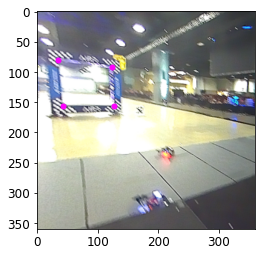

[34 80 124 92 127 156 43 156]


In [9]:
# HAVE AN INSIGHT OF CORNERS
def show_corners(I, points):
    plt.figure()
        # show the image
    # plot point p1 as a green circle, with markersize 10, and label "tip"
    # plot point p2 as a red circle, with markersize 10, and label "end"
    # plot a line starts at one point and end at another. 
    # Use a suitable color and linewidth for better visualization
    # Add a legend (tip, you can use the "label" keyword when you plot a point)
    
    plt.imshow(I)
    sc1 = plt.scatter(points[0], points[1], s=25, marker="o", color="magenta")
    sc2 = plt.scatter(points[2], points[3], s=25, marker="o", color="magenta")
    sc3 = plt.scatter(points[4], points[5], s=25, marker="o", color="magenta")
    sc4 = plt.scatter(points[6], points[7], s=25, marker="o", color="magenta")
    # done, show the image
    plt.show()

show_corners(imgs[0], corners_list[0][1])
print(corners_list[0][1])

[34 80 124 92 127 156 43 156]
255


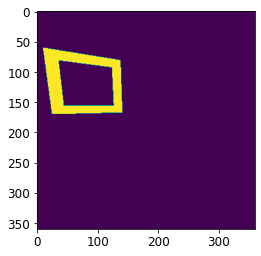

In [10]:
# HAVE AN INSIGHT OF MASKS
plt.figure()
plt.imshow(masks[0])
print(corners_list[0][1])
print(masks[0][80, 34]) # X/Y STANDS FOR COLUMN/ROW INDEX IN IMAGE
plt.show()

### 1.2 MAKE TRAIN AND TEST SET

#### 1.2.1 SAMPLE GRID POINTS AND MAKE LABELS ON AN IMAGE

In [11]:
# PATCH SIZE
WIN_SIZE = (28, 28, 3)
HALF_WIN_SIZE = (WIN_SIZE[0] // 2, WIN_SIZE[1] // 2, WIN_SIZE[2])

# SAMPLE POINTS WITH UNIFORM GRIDS(STRATEGY 1)
def sample_points_grid(I):
    # window centers
    W = I.shape[1]
    H = I.shape[0]
    
    step_size = (WIN_SIZE[0] // 4, WIN_SIZE[1] // 4)
    min_ys = range(0, H-WIN_SIZE[0]+1, step_size[0])
    min_xs = range(0, W-WIN_SIZE[1]+1, step_size[1])
    center_ys = range(HALF_WIN_SIZE[0], H-HALF_WIN_SIZE[0]+1, step_size[0])
    center_xs = range(HALF_WIN_SIZE[1], W-HALF_WIN_SIZE[1]+1, step_size[1])
    centers = np.array(np.meshgrid(center_xs, center_ys))
    centers = centers.reshape(2,-1).T
    centers = centers.astype(float) 
    
#     # add a bit of random offset
#     centers += np.random.rand(*centers.shape) * 10
    
    # discard points close to border where we can't extract patches
    centers = remove_points_near_border(I, centers)
    
    return centers

# REMOVE SAMPLED POINTS NEAR BORDER
def remove_points_near_border(I, points):
    W = I.shape[1]
    H = I.shape[0]

    # discard points that are too close to border
    points = points[points[:,0] > HALF_WIN_SIZE[1],:]
    points = points[points[:,1] > HALF_WIN_SIZE[0],:]
    points = points[points[:,0] < W - HALF_WIN_SIZE[1],:]
    points = points[points[:,1] < H - HALF_WIN_SIZE[0],:]
    
    return points

In [12]:
# SAMPLE POINTS WITH UNIFORM GRIDS AND ALSO AROUND GATES(STRATEGY 2)
def sample_points_around_gates(I, corners):    
    Nu = 60 # uniform samples(will mostly be background)
    Nt = 5 # samples at target locations(corners and between)
    
    target_std_dev = np.array(HALF_WIN_SIZE[:2]) / 8 # variance to add to locations

    # uniform samples
    upoints = sample_points_grid(I)
    idxs = np.random.choice(upoints.shape[0], Nu)
    upoints = upoints[idxs,:]
    
    points = upoints
    
    gate_pts = corners.copy().reshape(-1, 8)
    for idx in range(gate_pts.shape[0]):
        pts = gate_pts[idx]
        ptss = np.concatenate((pts, pts[2:], pts[:2]))
#         print(ptss)
        for pair_idx in range(4):
            p1 = ptss[2*pair_idx:2*pair_idx+2]
            p2 = ptss[2*pair_idx+8:2*pair_idx+8+2]
#             print(p1, p2)
            
            # sample around corners
            tpoints1 = np.random.randn(int(Nt),2)
            tpoints1 = tpoints1 * target_std_dev/3 + p1

#             tpoints2 = np.random.randn(int(2*Nt),2)
#             tpoints2 = tpoints2 * target_std_dev/3 + p2

            # sample over gate between corner points
            alpha = np.random.rand(Nt)
            tpoints3 = p1[None,:] * alpha[:,None] + p2[None,:] * (1. - alpha[:,None])
            tpoints3 = tpoints3 + np.random.randn(Nt,2) * target_std_dev/3

            # merge points
            points = np.vstack((points, tpoints1, tpoints3))
            
    # discard points close to border where we can't extract patches
    points = remove_points_near_border(I, points)
    
    return points

In [13]:
# MAKE LABELS FOR POINTS USING MASKS
def make_labels_for_points(I, points, mask):
    row_idxs = np.floor(points[:, 1]).astype(int)
    col_idxs = np.floor(points[:, 0]).astype(int)
#     print(points.shape)
#     print(row_idxs.shape, col_idxs.shape)
#     print(mask.shape)
    labels = mask[row_idxs, col_idxs]
    labels[labels > 0] = 1
#     print(labels.shape)
    
    return labels

(2209, 2)
(100, 2)


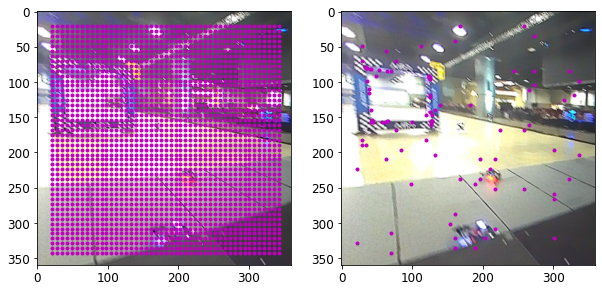

In [14]:
# HAVE AN INSIGHT TO SEE IF SAMPLING WORKS
I = imgs[0]
corners = corners_list[0][1]

points1 = sample_points_grid(I) # sampling strategy 1
points2 = sample_points_around_gates(I, corners) # sampling strategy 2
print(points1.shape)
print(points2.shape)

# plot both sampling strategies in a single figure using subplots
plt.figure(figsize=(10,12))
plt.subplot(1,2,1)
plt.imshow(I)
plt.plot(points1[:,0], points1[:,1], 'm.')

plt.subplot(1,2,2)
plt.imshow(I)
plt.plot(points2[:,0], points2[:,1], 'm.')

(100,)
(100, 2)


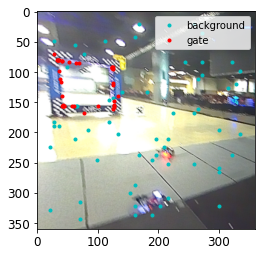

In [15]:
# HAVE AN INSIGHT TO SEE IF LABELING WORKS
CLASS_NAMES = [
    'background',   # class 0
    'gate',        # class 1
]
def plot_labeled_points(points, labels):
    plt.plot(points[labels == 0, 0], points[labels == 0, 1], 'c.', label=CLASS_NAMES[0])
    plt.plot(points[labels == 1, 0], points[labels == 1, 1], 'r.', label=CLASS_NAMES[1])
#     plt.plot(points[labels == 2, 0], points[labels == 2, 1], 'b.', label=CLASS_NAMES[2])
#     plt.plot(points[labels == 3, 0], points[labels == 3, 1], 'y.', label=CLASS_NAMES[3])

mask = masks[0]

labels2 = make_labels_for_points(I, points2, mask)
print(labels2.shape)
print(points2.shape)

plt.figure()
plt.imshow(imgs[0])
plot_labeled_points(points2, labels2)
plt.legend()

#### 1.2.2 GET PATCHES AND MAKE LABELS OF SAMPLED GRID POINTS

In [16]:
# GET PATCH AROUND A SAMPLED POINT
def get_patch_at_point(I, p):
    idx = p.astype(int)
    x = idx[0]
    y = idx[1]
    P = I[y-HALF_WIN_SIZE[0]:y+HALF_WIN_SIZE[0], x-HALF_WIN_SIZE[1]:x+HALF_WIN_SIZE[1], 0:HALF_WIN_SIZE[2]]
    
    return P

In [17]:
FEAT_SIZE = (28,28,3)

# USE RESIZE FUNCTION TO REDUCE THE DIMENSIONALITY TO FEATURE SIZE
def patch_to_vec(P):
    x = skimage.transform.resize(P, FEAT_SIZE).reshape(-1,1)
    x = np.squeeze(x, axis = 1)
    
    return x

In [18]:
# SAMPLE POINTS AND EXTRACT PATCHES FOR A SINGLE IMAGE
def extract_patches(I, corners, mask, strategy=None):
    
    # by default, if no strategy is explicitly defined, use strategy 2
    if strategy == 1:
        points = sample_points_grid(I)
    if strategy == 2 or strategy is None:
        points = sample_points_around_gates(I, corners)
    
    # determine the labels of the points
    labels = make_labels_for_points(I, points, mask)
    
    xs = []
    for p in points:
        P = get_patch_at_point(I, p)
        x = patch_to_vec(P)
        xs.append(x)
    X = np.array(xs)

    return X, labels, points

#### 1.2.3 MAKE TRAIN AND TEST SET FOR ALL IMAGES

In [19]:
def count_classes(labels):
#     counts = np.zeros((4,), dtype=int)
    counts = np.zeros((2,), dtype=int)
    u, cnts = np.unique(labels, return_counts=True)
    for idx in range(u.shape[0]):
        counts[u[idx]] = cnts[idx]
    return counts

In [20]:
# SAMPLE POINTS AND EXTRACT PATCHES FOR ALL IMAGES
def extract_multiple_images(idxs, Is, corners_list, masks, strategy=None):
    Xs = []
    ys = []
    points = []
    imgids = []

    for step, idx in enumerate(idxs):
        I = Is[idx]
        corners = corners_list[idx][1]
        mask = masks[idx]
        I_X, I_y, I_points = extract_patches(I, corners, mask, strategy=strategy)

        classcounts = count_classes(I_y)
        print(f'image {idx}, class count = {classcounts}')

        Xs.append(I_X)
        ys.append(I_y)
        points.append(I_points)
        imgids.append(np.ones(len(I_y),dtype=int)*idx)

    # Xs with shape(number of patches, dimension of feature vector 243)
    Xs = np.vstack(Xs)
    # ys is a vector with just one dimension so hstack horizontally append them as a long vector
    # so whatever a row or column vector, each idx represents a patch's label
    # ys with shape(number of patches, patch label)
    ys = np.hstack(ys)
    points = np.vstack(points)
    imgids = np.hstack(imgids)
    
    return Xs, ys, points, imgids

In [21]:
# NOTE: imgs, masks, corners_list

train_imgs = list(range(0,200))
test_imgs = list(range(200,len(imgs)))

X_train, y_train, points_train, imgids_train = \
            extract_multiple_images(train_imgs, imgs, corners_list, masks, strategy=2)

image 0, class count = [62 38]
image 1, class count = [65 60]
image 2, class count = [66 74]
image 3, class count = [65 75]
image 4, class count = [63 77]
image 5, class count = [67 73]
image 6, class count = [66 96]
image 7, class count = [63 98]
image 8, class count = [63 69]
image 9, class count = [57 76]
image 10, class count = [60 72]
image 11, class count = [66 58]
image 12, class count = [57 78]
image 13, class count = [66 65]
image 14, class count = [59 75]
image 15, class count = [57 83]
image 16, class count = [61 68]
image 17, class count = [57 76]
image 18, class count = [58 78]
image 19, class count = [61 63]
image 20, class count = [59 76]
image 21, class count = [ 63 114]
image 22, class count = [ 62 105]
image 23, class count = [ 56 107]
image 24, class count = [ 64 100]
image 25, class count = [ 65 103]
image 26, class count = [ 62 101]
image 27, class count = [ 58 107]
image 28, class count = [ 63 102]
image 29, class count = [ 66 104]
image 30, class count = [ 61 104

In [22]:
X_test, y_test, points_test, imgids_test = \
            extract_multiple_images(test_imgs, imgs, corners_list, masks, strategy=2)

image 200, class count = [62 78]
image 201, class count = [58 82]
image 202, class count = [65 75]
image 203, class count = [59 81]
image 204, class count = [58 82]
image 205, class count = [59 81]
image 206, class count = [62 78]
image 207, class count = [65 75]
image 208, class count = [60 80]
image 209, class count = [62 78]
image 210, class count = [62 78]
image 211, class count = [54 86]
image 212, class count = [56 84]
image 213, class count = [60 80]
image 214, class count = [56 84]
image 215, class count = [59 81]
image 216, class count = [58 82]
image 217, class count = [52 88]
image 218, class count = [58 82]
image 219, class count = [58 82]
image 220, class count = [50 90]
image 221, class count = [56 84]
image 222, class count = [56 84]
image 223, class count = [54 86]
image 224, class count = [55 85]
image 225, class count = [54 86]
image 226, class count = [59 81]
image 227, class count = [59 81]
image 228, class count = [57 83]
image 229, class count = [56 84]
image 230,

In [23]:
# HAVE AN INSIGNT OF OUTPUTS
print(X_train.shape, y_train.shape, points_train.shape, imgids_train.shape)
print(X_test.shape, y_test.shape, points_test.shape, imgids_test.shape)

(32912, 2352) (32912,) (32912, 2) (32912,)
(12488, 2352) (12488,) (12488, 2) (12488,)


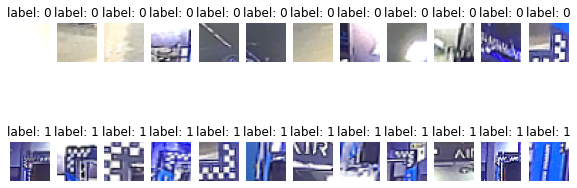

In [24]:
def plot_samples(Ps, labels):
    uls = np.unique(labels)
    nclasses = len(uls)
    nsamples = 12
    
    plt.figure(figsize=(10,4))
    
    for lidx, label in enumerate(uls):
        idxs = np.where(labels == label)[0]
        idxs = np.random.choice(idxs, nsamples, replace=False)
        
        for j, idx in enumerate(idxs):
            P = Ps[idx,:]
            P = P.reshape(FEAT_SIZE)
            
            plt.subplot(nclasses, nsamples, lidx*nsamples+j+1)
            plt.imshow(P, clim=(0,1))
            plt.axis('off')
            plt.title('label: %d' % label)
        
    plt.show()

plot_samples(X_train, y_train)

## 2. TRAIN THE MODEL

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda, Normalize
from torchsummary import summary

class GateDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
#         targets = torch.tensor(targets.copy())
#         self.targets = torch.nn.functional.one_hot(targets.to(torch.int64))
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, idx):
        img = self.data[idx]
#         print(img.shape)
        if self.transform:
            img = self.transform(img)
#         print(img.shape)
        
        target = self.targets[idx]

        return img, target

In [26]:
X_train = X_train.reshape(-1, FEAT_SIZE[0], FEAT_SIZE[1], FEAT_SIZE[2])
X_test = X_test.reshape(-1, FEAT_SIZE[0], FEAT_SIZE[1], FEAT_SIZE[2])
mean = np.mean(X_train)
var = np.std(X_train)
print(mean, var)

transform = transforms.Compose([ToTensor(), 
                                Normalize((0.5687,), (0.2426,))])

# Get data from torchvision.datasets
train_data = GateDataset(X_train, y_train, transform=transform)
test_data = GateDataset(X_test, y_test, transform=transform)

# Define data loaders used to iterate through dataset
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000)

0.5331271384445044 0.27496793763957933


In [27]:
print(len(train_data), len(test_data))

32912 12488


In [28]:
import torchvision.models as models

class GateResNet18(nn.Module):    
    def __init__(self, out_features):
        super(GateResNet18, self).__init__()
        
        self.resnet18 = models.resnet18()
        self.fc = nn.Linear(1000, out_features)

    def forward(self, x):
        x = self.resnet18(x)
        x = self.fc(x)
        
        return x

In [29]:
device = torch.device('cuda:0') if torch.cuda.is_available() \
                                        else torch.device('cpu')
print(device)

# in_channels = 3
# hidden_channels = [5, 6]
out_features = 2

# net = Net(in_channels, hidden_channels, out_features)
resnet18 = GateResNet18(out_features)
summary(resnet18, (3, 28, 28), device='cpu')

# Training parameters
learning_rate = 0.001
epochs = 15

# Initialize network
optimizer = torch.optim.Adam(resnet18.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

# Define list to store losses and performances of each iteration
train_losses = []
train_accs = []
test_accs = []

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14            

In [43]:
def evaluate_accuracy(data_loader, net, device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  #make sure network is in evaluation mode

    #init
    acc_sum = torch.tensor([0], dtype=torch.float32, device=device)
    n = 0

    for X, y in data_loader:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            X = X.float()
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0] #increases with the number of samples in the batch
    return acc_sum.item()/n

In [34]:
########################################
# ATTENTION: THIS NODE START TRAINING! #
########################################
for epoch in range(epochs):

    # Network in training mode and to device
    resnet18.train()
    resnet18.to(device)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch = x_batch.float()
        y_batch = y_batch.long()
        
        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         print(x_batch.shape, y_batch.shape)
#         print(x_batch[:3, :, 0, 0], y_batch[:3])
        # Set the gradients to zero
        optimizer.zero_grad()

        # Perform forward pass
        y_pred = resnet18(x_batch)

        # Compute the loss
#         print(y_batch.type(), y_pred.type())
        loss = criterion(y_pred, y_batch)
#         print(loss)
        train_losses.append(loss)
        
        # Backward computation and update
        loss.backward()
        optimizer.step()
#         break
        
#     break

    # Compute train and test error
    train_acc = 100*evaluate_accuracy(train_loader, resnet18.to('cpu'))
    test_acc = 100*evaluate_accuracy(test_loader, resnet18.to('cpu'))
    
    # Development of performance
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
    print('Accuracy of train set: {:.00f}%'.format(train_acc))
    print('Accuracy of test set: {:.00f}%'.format(test_acc))
    print('')

Epoch: 1
Accuracy of train set: 95%
Accuracy of test set: 91%

Epoch: 2
Accuracy of train set: 95%
Accuracy of test set: 91%

Epoch: 3
Accuracy of train set: 95%
Accuracy of test set: 92%

Epoch: 4
Accuracy of train set: 96%
Accuracy of test set: 92%

Epoch: 5
Accuracy of train set: 96%
Accuracy of test set: 91%

Epoch: 6
Accuracy of train set: 94%
Accuracy of test set: 90%

Epoch: 7
Accuracy of train set: 96%
Accuracy of test set: 89%

Epoch: 8
Accuracy of train set: 97%
Accuracy of test set: 91%

Epoch: 9
Accuracy of train set: 98%
Accuracy of test set: 90%

Epoch: 10
Accuracy of train set: 98%
Accuracy of test set: 91%

Epoch: 11
Accuracy of train set: 99%
Accuracy of test set: 90%

Epoch: 12
Accuracy of train set: 99%
Accuracy of test set: 91%

Epoch: 13
Accuracy of train set: 99%
Accuracy of test set: 90%

Epoch: 14
Accuracy of train set: 99%
Accuracy of test set: 92%

Epoch: 15
Accuracy of train set: 99%
Accuracy of test set: 91%



In [35]:
print((X_train[:3, 0, 0, :] - mean) / var)
print(y_train[:3])

[[ 0.14336901  0.2432024   0.18615475]
 [ 0.10058327  0.21467857 -0.04203585]
 [ 1.45546495  1.07039331 -0.76939338]]
[0 0 0]


In [36]:
torch.save(resnet18.state_dict(), 'learned_weights/gate_det_cnn.pt')

### 3. TEST ON AN IMAGE WHEN WORKING

In [44]:
import time

# LOAD MODEL
model = GateResNet18(out_features=2)
model.load_state_dict(torch.load('learned_weights/gate_det_cnn.pt'))
model.eval()
model.to(device)

# LOAD CURRENT IMAGE, PREPROCESSING THE DATA
start_time = time.time()
I = imgs[280:281]
# corners = corners_list[0][1]
X_test_0, y_test_0, points_0, imgids_0 = \
            extract_multiple_images(range(1), I, corners_list, masks, strategy=1)
X_test_0 = X_test_0.reshape(-1, FEAT_SIZE[0], FEAT_SIZE[1], FEAT_SIZE[2])
test_data_0 = GateDataset(X_test_0, y_test_0, transform=transform)
test_loader_0 = DataLoader(test_data_0, batch_size=y_test_0.shape[0])

# INPUT THE IAMGE TO THE MODEL
y_pred_0 = []

for i, (x_batch, y_batch) in enumerate(test_loader_0): # NOTE: ONLY ONE ITERATION HERE
    x_batch = x_batch.float()
    y_batch = y_batch.long()

    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    y_pred_0 = model(x_batch)
    
# GENERATE THE OUTPUT MASK
y_pred_0_ind = torch.argmax(y_pred_0, axis=1)
# print(torch.unique(y_pred_0_ind))
pred_mask_0 = np.zeros((I[0].shape[0], I[0].shape[1]))
points_0 = points_0.astype(int)
# pred_mask_0[points_0[:, 1], points_0[:, 0]] = y_pred_0_ind
gate_ind, = torch.where(y_pred_0_ind == 1)
# print(gate_ind.shape)
for ind in range(gate_ind.shape[0]):
    x = points_0[gate_ind[ind], 1]
    y = points_0[gate_ind[ind], 0]
    pred_mask_0[x-3:x+4, y-3:y+4] = 1
# pred_mask_0[:21, 21:344] = pred_mask_0[21, 21:344]
# pred_mask_0[344:, 21:344] = pred_mask_0[343, 21:344]
# pred_mask_0[21:344, :21] = pred_mask_0[21:344, 21].reshape(-1, 1)
# pred_mask_0[21:344, 344:] = pred_mask_0[21:344, 343].reshape(-1, 1)

end_time = time.time()
    
print("Generate {0} patches; {1} seconds.".format(len(test_data_0), \
                                                    end_time - start_time), end='\r')

image 0, class count = [2089  120]


In [45]:
print(y_pred_0.shape)
print(y_pred_0[:5, :])

torch.Size([2209, 2])
tensor([[ 6.1873, -5.5884],
        [ 5.6519, -5.0978],
        [ 5.1504, -4.6380],
        [ 4.7771, -4.3216],
        [ 4.2204, -3.8278]], device='cuda:0', grad_fn=<SliceBackward>)


In [46]:
# NOTE: PATCH STEP SIZE 7, EACH COVERING 6 PIXELS NEXT TO IT
print(points_0.shape)

(2209, 2)


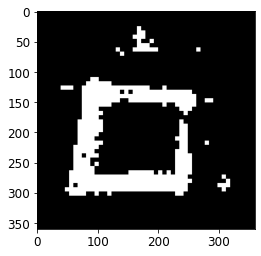

In [47]:
plt.figure()
plt.imshow(pred_mask_0, 'gray')
plt.show()

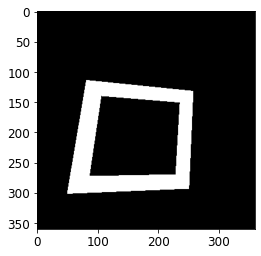

In [49]:
plt.figure()
plt.imshow(masks[280], 'gray')
plt.show()

## 4. ROC Curve

In [65]:
pred_act_0 = np.zeros((I[0].shape[0], I[0].shape[1]))
for ind in range(y_pred_0.shape[0]):
    x = points_0[ind, 1]
    y = points_0[ind, 0]
    pred_act_0[x-3:x+4, y-3:y+4] = y_pred_0[ind, 1].cpu().detach().numpy()
# pred_mask_0[:21, 21:344] = pred_mask_0[21, 21:344]
# pred_mask_0[344:, 21:344] = pred_mask_0[343, 21:344]
# pred_mask_0[21:344, :21] = pred_mask_0[21:344, 21].reshape(-1, 1)
# pred_mask_0[21:344, 344:] = pred_mask_0[21:344, 343].reshape(-1, 1)

In [77]:
import ROC

# Change ONLY the following line:
Values = pred_act_0;

# make it a flat list of values, in the right order:
Values = Values.flatten();

classes = masks[0]
classes[classes > 0] = 1
classes = classes.flatten()

# get the ROC curve:
TP, FP = ROC.get_ROC_curve(Values, classes)

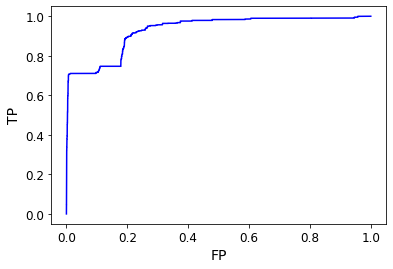

In [78]:
# plot the ROC curve:
plt.figure()
plt.plot(FP, TP, 'b')
plt.ylabel('TP')
plt.xlabel('FP')

In [76]:
print(np.unique(masks[0].flatten()))

[  0 255]
